# Exploring Arrow Ecosystem

In this Jupyter notebook, we'll explore the Arrow ecosystem. For that, we'll use [AWS Digital Assets Dataset](https://github.com/aws-samples/digital-assets-examples) which pulls data from the public Ethereum blockchain and normalizes data into tabular data structures for blocks, transactions, and additional tables for data inside a block. 

The dataset is available in Parquet format on Amazon S3 at the following location: `s3://aws-public-blockchain/v1.0/eth/`.

## Setup 

In [4]:
import duckdb

import pyarrow as pa
import pyarrow.dataset as ds

from deltalake import DeltaTable
from deltalake.writer import write_deltalake
from pyarrow import fs

con = duckdb.connect()


In [24]:
s3 = fs.S3FileSystem(region="us-east-2")
s3_eth_blocks_location = "s3://aws-public-blockchain/v1.0/eth/blocks"


In [25]:
blocks = ds.dataset(s3_eth_blocks_location, format="parquet", partitioning="hive")


In [1]:
blocks.head(5).to_pandas()


NameError: name 'blocks' is not defined

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

<Axes: xlabel='date'>

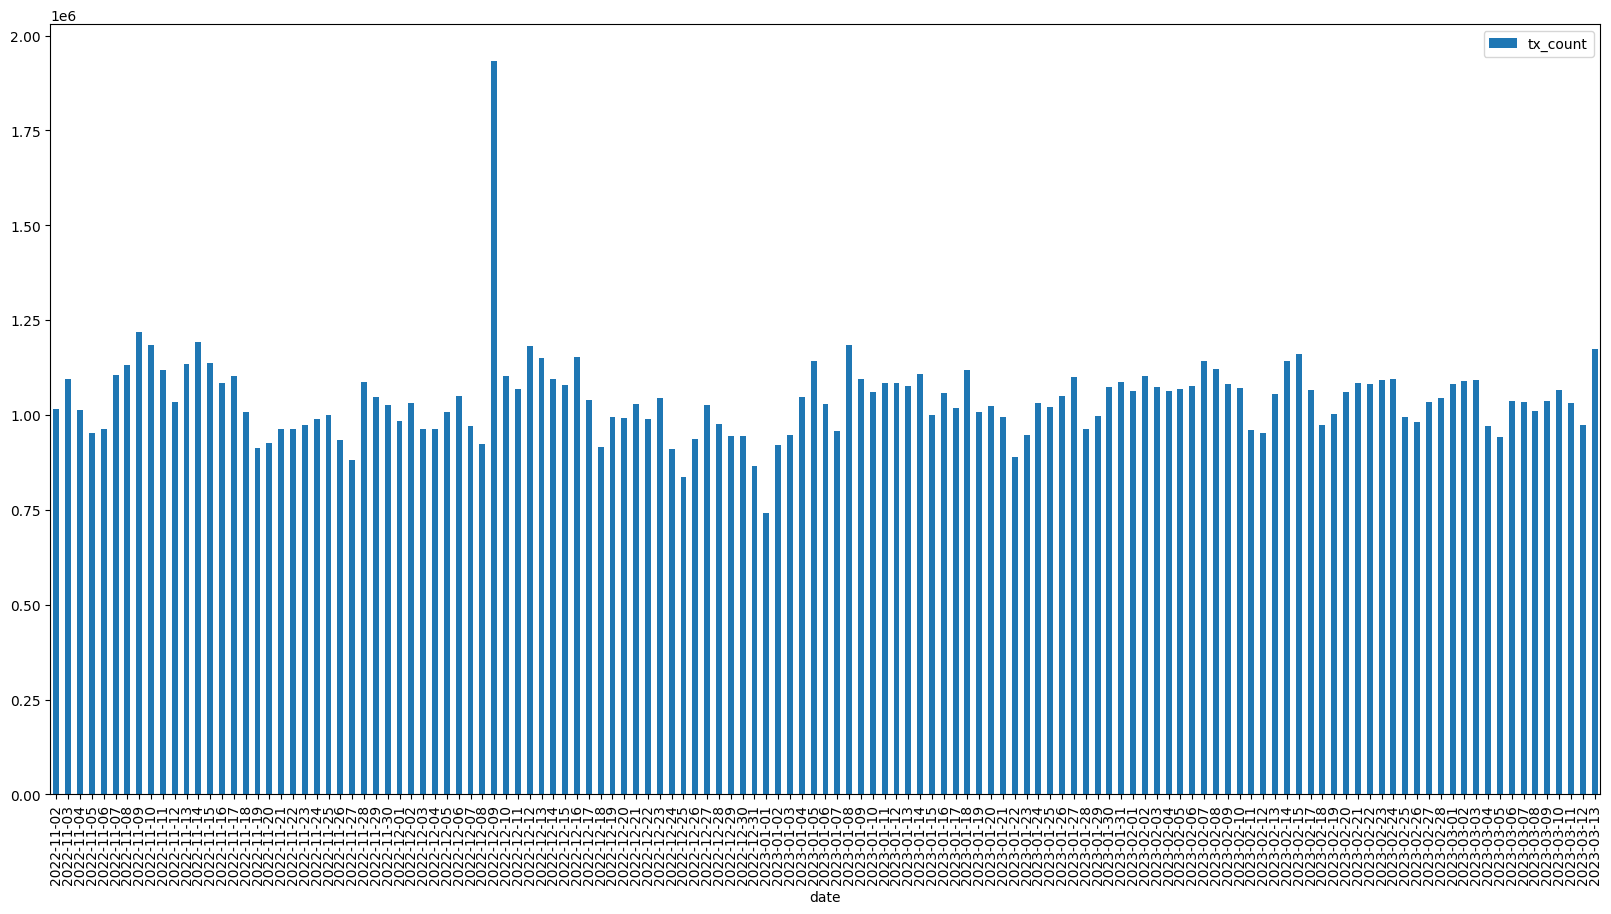

In [ ]:
con.execute(
    """
    select 
        date,
        sum(transaction_count) as tx_count 
    from blocks 
    where 
        date > '2023-01-01'
    group by date 
    order by date
    """
).df().plot(x="date", y="tx_count", kind="bar", figsize=(20, 10))


In [ ]:
scanner = blocks.scanner(
    columns=["difficulty", "hash", "miner", "state_root", "date"],
    filter=(ds.field("date") > "2022-12-01") & (ds.field("date") < "2023-01-01"),
)


In [ ]:
scanner.head(5).to_pandas()


,difficulty,hash,miner,state_root,date
0,0.0,0x4379e19e699cfadfec8f4066b77e75725159c16ad7f0...,0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,0x75b981d534e8a6673294aa37fc4716bc4f91958094fa...,2022-12-02
1,0.0,0x36055641b76d077f3594c076309bdd5bd8b9f3f189e5...,0x690b9a9e9aa1c9db991c7721a92d351db4fac990,0xd4e657b856665dccddbf5d607fbca13cf6c2b30a108c...,2022-12-02
2,0.0,0x8aa19b0cf8483e5371b4414dc732071bfe861af61ed4...,0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,0x1ade2aadccb69308d2b377aeca56e6e0e289a4d6b02f...,2022-12-02
3,0.0,0x85990a167ca1780e8999d5d4d14d4b8688c02602fb8d...,0x473780deaf4a2ac070bbba936b0cdefe7f267dfc,0xa857a789b45c7b14bd574aa55542a2de5c9f6ad3aaa0...,2022-12-02
4,0.0,0x13b507ab2b8ec4185bd80ca7337ac4927b287e0e40db...,0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,0x30df300050514ba4f00e7e05637ab0aa383b9cb2e067...,2022-12-02


In [ ]:
con.execute(
    """
select
    count(*) as block_count
from scanner
"""
).df()


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,block_count
0,214793


In [ ]:
write_deltalake(
    "../datasets/blocks", scanner.to_reader(), mode="overwrite", partition_by=["date"]
)
